In [1]:
import sys, os
cwd = os.getcwd()
if os.path.basename(cwd) == 'app':
    project_root = os.path.abspath(os.path.join(cwd, '..'))
else:
    project_root = cwd
import myutils
import matplotlib.pyplot as plt


In [2]:
def slice_events(events, t_pid, asynchronous = False):
    # Relevent processes are tracked dynamically
    pid_set = {t_pid}
    binders = dict()
    unix_streams = dict()
    unix_dgrams_waiting = set()
    unix_dgrams = dict()

    tgid2source_tids = dict()

    out_flows_slice = []
    in_flows_slice = []

    e_index = 0
    for e in events:
        # Forward slicing for output operations (write or ioctl, which is considered "potential" read+write)
        #######################################################################
        tgid = e['tgid']
        tid = e['tid']
        #pid = myutils.get_pid(tid, tgid, tgid_slicing)
        event = e['event']

        # Force only per-thread-synchronous calls
        if tgid == t_pid and not asynchronous:
            for pids in tgid2source_tids:
                if tid in tgid2source_tids[pids]:
                    tgid2source_tids[pids].remove(tid)
                    if len(tgid2source_tids[pids]) == 0:
                        pid_set.remove(pids)
                    # Remove the tid associated with the thread of the examined process and if no other thread of the examined process
                    # is in the set, disassociate the tgid

        if tgid in pid_set:
            # If the process is associated with the examined process
            if tgid == t_pid:
                sources = set([tid])
            else:
                sources = tgid2source_tids[tgid]

            if event == 'binder_transaction':
                binders[e['details']['transaction']] = sources
            elif event == 'unix_stream_sendmsg':
                if e['details']['topid'] in unix_streams:
                    unix_streams[e['details']['topid']] = unix_streams[e['details']['topid']].union(sources)
                else:
                    unix_streams[e['details']['topid']] = sources
            elif event == 'unix_dgram_sendmsg':
                unix_dgrams_waiting.add(tid)
            elif event == 'sock_queue_tail' and tid in unix_dgrams_waiting:
                if e['details']['inode'] in unix_dgrams:
                    unix_dgrams[e['details']['inode']] = unix_dgrams[e['details']['inode']].union(sources)
                else:
                    unix_dgrams[e['details']['inode']] = sources
                unix_dgrams_waiting.remove(tid)
            elif (event == 'write_probe' and e['details']['pathname'] != 'null') or (event == 'ioctl_probe') or (event == 'inet_sock_set_state'):
                # We consider socket state transitions both for input and output events
                # Add event as output event for this instance
                out_flows_slice.append(e_index)

        # If a process receives a binder transaction originating from a tracked process, then the process also becomes tracked inheriting its sources
        if event == 'binder_transaction_received' and e['details']['transaction'] in binders:
            if tgid not in pid_set:
                pid_set.add(tgid)
            if tgid in tgid2source_tids:
                tgid2source_tids[tgid] = tgid2source_tids[tgid].union(binders[e['details']['transaction']])
            else:
                tgid2source_tids[tgid] = binders[e['details']['transaction']]
            del binders[e['details']['transaction']]
        elif event == 'unix_stream_recvmsg' and tgid in unix_streams:
            if tgid not in pid_set:
                pid_set.add(tgid)
            if tgid in tgid2source_tids:
                tgid2source_tids[tgid] = tgid2source_tids[tgid].union(unix_streams[tgid])
            else:
                tgid2source_tids[tgid] = unix_streams[tgid]
            del unix_streams[tgid]
        elif event == 'unix_dgram_recvmsg' and e['details']['inode'] in unix_dgrams:
            if tgid not in pid_set:
                pid_set.add(tgid)
            if tgid in tgid2source_tids:
                tgid2source_tids[tgid] = tgid2source_tids[tgid].union(unix_dgrams[e['details']['inode']])
            else:
                tgid2source_tids[tgid] = unix_dgrams[e['details']['inode']]
            del unix_dgrams[e['details']['inode']]

        e_index += 1
###############################################################################
    pid_set = {t_pid}
    binders = dict()
    unix_streams = dict()
    unix_dgrams_waiting = set()
    unix_dgrams = dict()

    tgid2source_tids = dict()

    e_index = len(events) - 1
    for e in reversed(events):
    # Backward slicing for input operations (read or ioctl/inet, which are considered "potential" read/write)
        tgid = e['tgid']
        tid = e['tid']
        #pid = myutils.get_pid(tid, tgid, tgid_slicing)
        event = e['event']

        # same as the forward path. If a thread of the examined process does something, we assume it means that it is not waiting to get data
        if tgid == t_pid and not asynchronous:
            for pids in tgid2source_tids:
                if tid in tgid2source_tids[pids]:
                    tgid2source_tids[pids].remove(tid)
                    if len(tgid2source_tids[pids]) == 0:
                        pid_set.remove(pids)
                    # Remove the tid associated with the thread of the examined process and if no other thread of the examined process
                    # is in the set, disassociate the tgid

        if tgid in pid_set:

            # If the process is associated with the examined process
            if tgid == t_pid:
                sources = set([tid])
            else:
                sources = tgid2source_tids[tgid]

            if event == 'binder_transaction_received':
                binders[e['details']['transaction']] = sources
            elif event == 'unix_stream_recvmsg':
                if e['details']['frompid'] in unix_streams:
                    unix_streams[e['details']['frompid']] = unix_streams[e['details']['frompid']].union(sources)
                else:
                    unix_streams[e['details']['frompid']] = sources
            elif event == 'unix_dgram_recvmsg':
                if e['details']['inode'] in unix_dgrams:
                    unix_dgrams[e['details']['inode']] = unix_dgrams[e['details']['inode']].union(sources)
                else:
                    unix_dgrams[e['details']['inode']] = sources

            elif event == 'read_probe' or event == 'ioctl_probe' or (event == 'inet_sock_set_state'):
                # Add event as input event for this instance
                in_flows_slice.append(e_index)
                #print('Input event')


        # If a process sends a binder transaction to a tracked process, then the process also becomes tracked - of course we are going in reverse now!
        if event == 'binder_transaction' and e['details']['transaction'] in binders:
            if tgid not in pid_set:
                pid_set.add(tgid)
            if tgid in tgid2source_tids:
                tgid2source_tids[tgid] = tgid2source_tids[tgid].union(binders[e['details']['transaction']])
            else:
                tgid2source_tids[tgid] = binders[e['details']['transaction']]
            del binders[e['details']['transaction']]
        if event == 'unix_stream_sendmsg' and tgid in unix_streams:
            if tgid not in pid_set:
                pid_set.add(tgid)
            if tgid in tgid2source_tids:
                tgid2source_tids[tgid] = tgid2source_tids[tgid].union(unix_streams[tgid])
            else:
                tgid2source_tids[tgid] = unix_streams[tgid]
            del unix_streams[tgid]
        # This could be improved but it is OK for now
        elif event == 'sock_queue_tail' and e['details']['inode'] in unix_dgrams:
            if tgid not in pid_set:
                pid_set.add(tgid)
            if tgid in tgid2source_tids:
                tgid2source_tids[tgid] = tgid2source_tids[tgid].union(unix_dgrams[e['details']['inode']])
            else:
                tgid2source_tids[tgid] = unix_dgrams[e['details']['inode']]
            # Note that the unix_dgrams[e['details']['inode']] is not consumed and remains there for eternity
            # The algorithm here could be considerably improved to match send and receive messages as uniquely as possible

        e_index -= 1

    # After both passes, merge everything to one sequence

    merged = []
    i = 0
    j = 0

    len_in = len(in_flows_slice)
    len_out = len(out_flows_slice)

    #if len_in == 0 and len_out == 0:
        #filtered_slice['in'] = []
        #filtered_slice['out'] = []
    #    merged = []

    while (i < len_in) and (j < len_out):
        if in_flows_slice[i] < out_flows_slice[j]:
            merged.append(in_flows_slice[i])
            i += 1
        else:
            merged.append(out_flows_slice[j])
            j += 1

    merged = merged + in_flows_slice[i:] + out_flows_slice[j:]
    # Eliminate duplicate ioctl entries -- this needs improvement
    merged_unique_index = []
    seen = set()
    for e_index in merged:
        if e_index in seen:
            continue
        else:
            seen.add(e_index)
            merged_unique_index.append(e_index)

    merged_unique = []
    for e_index in merged_unique_index:
        merged_unique.append(events[e_index])

    filtered_events = []
    for e in merged_unique:
        # Filter our remnant api logging if any, and binder transactions incl. their ioctl calls
        if (e['event'] == 'write_probe' and e['details']['pathname'] != 'null') or (e['event'] == 'ioctl_probe' and e['details']['pathname'] != 'binder' and e['details']['pathname'] != 'hwbinder') or (e['event'] != 'write_probe' and e['event'] != 'ioctl_probe' and 'binder' not in e['event']):
            light_e = dict()
            light_e['event'] = e['event']
            light_e['details'] = e['details']
            filtered_events.append(light_e.copy())
    new_events = myutils.clean_event_list_withpath(filtered_events)
    return new_events

In [3]:
def slice_file(directory, file, window_size, overlap, logger, asynchronous):
    logger.info(80*'#')
    filename = os.path.join(directory, file)
    kdev2pathnames = dict()
    kdevs_trace = []
    apis_trace = []
    ## We trace TCP state transitions from processes with the target tgid
    TCP_trace = []

    sensitive_data_trace = {'contacts': [], 'sms': [], 'calendar': [], 'call_logs': []}
    all_sensitive_events = {'contacts': [], 'sms': [], 'calendar': [], 'call_logs': []}
    sensitive_resources = myutils.load_sensitive_resources()

    logger.info(file)
    raw_events = myutils.parse_ftrace_log(filename)
    logger.info(file + ' ' + str(len(raw_events)))

    if sensitive_resources:
        for event in raw_events:
            _, sensitive_type = is_filtered(event, sensitive_resources, True)
            if sensitive_type:
                all_sensitive_events[sensitive_type].append(event)
        #for testing
        for data_type, events in all_sensitive_events.items():
            if events:
                logger.info(f"Access to {data_type} detected! Found {len(events)} events.")
            else:
                logger.info(f"No access to {data_type} detected in this trace.")

    t_pid = 0
    t_pid = find_process(raw_events, file)
    print(t_pid)
    if t_pid == 0:
        return []

    # Remove API logging not associated with target pid
    events_pruned = remove_apis(raw_events)
    logger.info('After removing excess API logging: ' + file + ' ' + str(len(events_pruned)))
    # Keep devices discovered per window and associated apis
    j = 0

    step = window_size - overlap

    if step <= 0:
        raise ValueError("Overlap must be less than the window size.")

    if window_size > len(events_pruned):
        window_size = len(events_pruned)

    # Slide the window over the event sequence
    i = 0
    while(i < len(events_pruned)):
        end = i + window_size
        begin = i
        if end > len(events_pruned):
            end = len(events_pruned)
            if len(events_pruned) - window_size >= 0:
                begin = len(events_pruned) - window_size
            else:
                begin = 0
        window = events_pruned[begin:end]

        try:
            relevant_events = slice_events(window, t_pid, asynchronous)
            tcp_window = get_tcp_events(relevant_events)
            window_sensitive = {data_type: [] for data_type in sensitive_data_trace}

            if sensitive_resources:
                for event in window:
                    _, sensitive_type = is_filtered(event, sensitive_resources, True)
                    if sensitive_type:
                        window_sensitive[sensitive_type].append(event)

                for data_type in sensitive_data_trace:
                    sensitive_data_trace[data_type].append(window_sensitive[data_type])


        except Exception as e:
            print(f"Error processing window: {str(e)}")
            print(file)
            print(t_pid)
            if end == len(events_pruned):
                i = end
            else:
                i += step
            continue


        #print('Number of sliced events', len(relevant_events))

        # Here we consider all API begin or end events and count all instances even when they are not completed in the window
        #raw_start = window[0]['raw']
        #raw_end = window[-1]['raw']
        #relevant_instances = myutils.extract_relevant_instances_all(raw_events[raw_start:raw_end], t_pid)
        #print('Number of APIs', len(relevant_instances))
        kdev2count_window = dict()
        kdev2pathname_window = dict()
        for e in relevant_events:
            filtered = is_filtered(e)
            if not filtered:
                kdev = e['details']['k_dev']
                #(major,minor) = myutils.calculate_major_minor(e['details']['k_dev'])
                #kdev = major
                pathname = e['details']['pathname']
                if kdev not in kdev2count_window:
                    kdev2count_window[kdev] = 1
                else:
                    kdev2count_window[kdev] += 1
                if kdev not in kdev2pathname_window:
                    kdev2pathname_window[kdev] = [pathname]
                else:
                    if pathname not in kdev2pathname_window[kdev]:
                        kdev2pathname_window[kdev].append(pathname)
        #print(len(relevant_instances))
        #print(kdev2pathname)

        for kdev in kdev2pathname_window:
            if kdev not in kdev2pathnames:
                kdev2pathnames[kdev] = set(kdev2pathname_window[kdev])
            else:
                kdev2pathnames[kdev] = kdev2pathnames[kdev].union(set(kdev2pathname_window[kdev]))

        apis_window = []
        kdevs_trace.append(kdev2count_window.copy())
        apis_trace.append(apis_window.copy())
        #
        TCP_trace.append(tcp_window.copy())
        #######################################################################

        if end == len(events_pruned):
            i = end
        else:
            i += step
    return [file, kdev2pathnames, kdevs_trace, apis_trace, TCP_trace, sensitive_data_trace, all_sensitive_events]

In [4]:
def find_process(events, f):
    t_pid = 0
    found_process = False
    for e in events:
        if e['process'].lower() == f[-21:-6].lower():
            found_process = True
            process_name = e['process']
            t_pid = e['tgid']
    return t_pid

In [5]:
def remove_apis(events):
    cleaned_events = []
    i = -1
    for e in events:
        i += 1
        e['raw'] = i
        # Remove API logging and also monkey process operations
        try:
            if not(e['event'] == 'write_probe' and e['details']['pathname'] == 'null' and e['details']['count'] > 999999) and 'monkey' not in e['process']:
                cleaned_events.append(e.copy())
        except:
            print(e)
    return cleaned_events

In [6]:
def get_tcp_events(window):
    tcp_events = []
    for e in window:
        if e['event'] == "inet_sock_set_state":
            #print(e)
            tcp_events.append(e.copy())
    return tcp_events

In [7]:
def is_filtered(e, sensitive_resources=None, track_sensitive=False):
    filtered = True
    sensitive_type = None
    filtered_pathnames = []

    if 'details' in e and 'k_dev' in e['details']:
        if (e['event'] in ['read_probe', 'write_probe', 'ioctl_probe']) and e['details']['k_dev'] != 0:
            filtered = False
            try:
                if 'pathname' in e['details'] and e['details']['pathname'] in filtered_pathnames:
                    filtered = True
            except:
                print(e)
                filtered = True

    if track_sensitive and sensitive_resources and 'details' in e:
        try:
            for dtype in ['contacts', 'sms', 'calendar', 'call_logs']:
                if dtype in sensitive_resources:
                    res = sensitive_resources[dtype]
                    if e['details'].get('s_dev_inode') == res['st_dev32'] and e['details'].get('inode') == res['inode']:
                        sensitive_type = dtype
                        break
        except Exception as ex:
            print(f"Error checking sensitive type: {str(ex)}")

    if not track_sensitive:
        return filtered

    return filtered, sensitive_type

In [8]:
def produce_stats(file2kdevs_windows, cat2num, devs2num):
    total_windows = len(file2kdevs_windows)
    total_categories = len(cat2num)
    total_devices = len(devs2num)

    # Find the most frequently used category
    most_used_cat = None
    max_count = 0
    for cat, count in cat2num.items():
        if count > max_count:
            max_count = count
            most_used_cat = cat

    # Find the top 5 most used devices
    sorted_devices = sorted(devs2num.items(), key=lambda x: x[1], reverse=True)
    top3_devices = sorted_devices[:5]

    print("\n===== Statistics Summary =====")
    print(f"Total windows: {total_windows}")
    print(f"Total categories used: {total_categories}")
    print(f"Total unique devices: {total_devices}")

    if most_used_cat is not None:
        print(f"Most used category: {most_used_cat} (count: {max_count})")

    print("Top 5 devices by usage:")
    for d, c in top3_devices:
        print(f"  - Device {d}, count {c}")
    print("================================\n")

In [9]:
import logging

# Configure the logging system
logging.basicConfig(
    level=logging.DEBUG,  # Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(process)d - %(levelname)s - %(message)s',  # Log format
    handlers=[
        logging.StreamHandler()  # Output logs to the notebook cell
    ]
)

logger = logging.getLogger("MyLogger")

In [10]:
#cat2stars = myutils.load_file('cat2stars_curated.txt')
cat2devs = myutils.load_file('../data/mappings/cat2devs.txt')
dev2cat = dict()
for cat in cat2devs:
    for dev in cat2devs[cat]:
        dev2cat[dev] = cat

In [11]:
# Test single app
import sys

directory = './'
filepath = '../data/traces/photo_remote_phone.child2024.trace'

window_size = 5000
overlap = 1000
asynchronous = True

result_packed = slice_file(directory, filepath, window_size, overlap, logger, asynchronous)

if len(result_packed) == 0:
    print('Application Activity not found')
    sys.exit(1)
else:
    dev2pathnames_single = result_packed[1]
    kdevs_windows_single = result_packed[2]
    print(len(kdevs_windows_single))
    file2apis_windows_single = result_packed[3]
    file2TCP_windows_single = result_packed[4]
    sensitive_data_trace = result_packed[5]
    contacts_windows = sensitive_data_trace['contacts']

    devs2num = dict()
    apis2num = dict()
    cat2num = dict()
    cats2windows = []
    for temp_list in kdevs_windows_single:
        cats_window = []
        for kdev in temp_list:
            if kdev not in devs2num:
                devs2num[kdev] = 1
            else:
                devs2num[kdev] += 1
            if kdev in dev2cat:
                cat_temp = dev2cat[kdev]
                if cat_temp not in cat2num:
                    cat2num[cat_temp] = 1
                else:
                    cat2num[cat_temp] += 1
                if cat_temp not in cats_window:
                    cats_window.append(cat_temp)
        cats2windows.append(cats_window)

    for temp_list in file2apis_windows_single:
        for api in temp_list:
            if api not in apis2num:
                apis2num[api] = 1
            else:
                apis2num[api] += 1
    for dev in devs2num:
        if dev in dev2pathnames_single:
            print(dev, dev2pathnames_single[dev], devs2num[dev])
        else:
            print(dev, devs2num[dev])
    for cat in cat2num:
        print(cat, cat2num[cat])
    print(cats2windows)

produce_stats(kdevs_windows_single, cat2num, devs2num)

2025-05-14 19:16:57,508 - 41231 - INFO - ################################################################################
2025-05-14 19:16:57,510 - 41231 - INFO - ../data/traces/photo_remote_phone.child2024.trace
2025-05-14 19:16:59,260 - 41231 - INFO - ../data/traces/photo_remote_phone.child2024.trace 64708
2025-05-14 19:16:59,331 - 41231 - INFO - No access to contacts detected in this trace.
2025-05-14 19:16:59,332 - 41231 - INFO - No access to sms detected in this trace.
2025-05-14 19:16:59,333 - 41231 - INFO - No access to calendar detected in this trace.
2025-05-14 19:16:59,334 - 41231 - INFO - No access to call_logs detected in this trace.
2025-05-14 19:16:59,504 - 41231 - INFO - After removing excess API logging: ../data/traces/photo_remote_phone.child2024.trace 64708


20374
16
10485885 {'ashmem02ba1549-1754-4bd0-b93a-58d486fdaeb5'} 13
512753665 {'acd-com.google.usf.non_wake_up'} 13
512753666 {'acd-com.google.chre'} 4
521142272 {'umts_ipc0'} 2
521142293 {'gnss_boot'} 1
512753664 {'acd-com.google.usf'} 7
10485880 {'gnss_ipc'} 4
1048587 {'kmsg'} 6
521142294 {'gnss_dump'} 1
10485855 {'mali0'} 9
260046859 {'system-uncached'} 8
260046858 {'system'} 11
521142284 {'oem_ipc0'} 3
508559373 {'lwis-sensor-taotie-uw'} 4
508559371 {'lwis-sensor-boitata'} 9
10485851 {'ispolin_ranging'} 9
260046862 {'sensor_direct_heap'} 3
1048585 {'urandom'} 5
513802240 {'aoc'} 2
508559361 {'lwis-isp-fe'} 7
508559370 {'lwis-votf'} 7
508559366 {'lwis-be-core'} 8
508559382 {'lwis-slc'} 4
508559368 {'lwis-gtnr-align'} 7
508559383 {'lwis-dpm'} 6
508559362 {'lwis-gdc0'} 7
508559364 {'lwis-mcsc'} 7
508559381 {'lwis-flash-lm3644'} 2
508559377 {'lwis-act-cornerfolk'} 7
508559367 {'lwis-gtnr-merge'} 7
509607936 {'gxp'} 7
508559380 {'lwis-ois-djinn'} 7
508559360 {'lwis-top'} 6
511705089 {'e

2025-05-14 19:16:59,895 - 41231 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-14 19:16:59,900 - 41231 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-14 19:16:59,906 - 41231 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-05-14 19:16:59,907 - 41231 - DEBUG - findfont: score(FontEntry(fname='/home/foiv/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-14 19:16:59,908 - 41231 - DEBUG - findfont: score(FontEntry(fname='/home/foiv/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-05-14 19:16:59,908 - 41231 - DEBUG - findfon

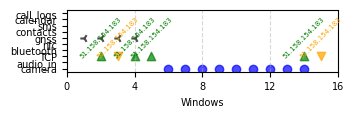

In [12]:
# Plotting
# Include "Internet" event
i = 0
for w in file2TCP_windows_single:
    if len(w) != 0:
        cats2windows[i].append(w[0]['details']['newstate'] + ': ' + w[0]['details']['daddr'])
    i += 1

#print(cats2windows)

events = cats2windows
N = len(events)

import os
import matplotlib.pyplot as plt
import numpy as np
# Define event types, markers, and colors
event_markers = {
    "camera": "o",          # Circle
    "TCP_SYN_SENT": "^",    # Triangle Up
    "audio_in": "x",
    "bluetooth": "1",
    "nfc": "2",
    "gnss": "3",
    "TCP_LAST_ACK": "v",     # Triangle Down
    "contacts": "*",
    "sms": "s",
    "calendar": "D",
    "call_logs": "p"
}
event_colors = {
    "camera": "blue",
    "audio_in": "red",
    "TCP_SYN_SENT": "green",
    "TCP_LAST_ACK": "orange",
    "bluetooth": "grey",
    "nfc": "magenta",
    "gnss": "black",
    "contacts": "purple",
    "sms": "brown",
    "calendar": "cyan",
    "call_logs": "olive"
}

# Prepare data for plotting
x_values, y_values, markers, colors, annotations = [], [], [], [], []
event_types = ["camera", "audio_in", "TCP", "bluetooth", "nfc", "gnss", "contacts", "sms", "calendar", "call_logs"]  # TCP is a combined category

for i, ev_list in enumerate(events):

    if i < len(contacts_windows) and len(contacts_windows[i]) > 0:
        if "contacts" not in ev_list:
            ev_list.append("contacts")
    if 'sms' in sensitive_data_trace and i < len(sensitive_data_trace['sms']) and len(sensitive_data_trace['sms'][i]) > 0:
        if "sms" not in ev_list:
            ev_list.append("sms")
    if 'calendar' in sensitive_data_trace and i < len(sensitive_data_trace['calendar']) and len(sensitive_data_trace['calendar'][i]) > 0:
        if "calendar" not in ev_list:
            ev_list.append("calendar")
    if 'call_logs' in sensitive_data_trace and i < len(sensitive_data_trace['call_logs']) and len(sensitive_data_trace['call_logs'][i]) > 0:
        if "call_logs" not in ev_list:
            ev_list.append("call_logs")

    for ev in ev_list:
        if ev.startswith("TCP_SYN_SENT"):
            ev_type = "TCP"
            marker = event_markers["TCP_SYN_SENT"]
            color = event_colors["TCP_SYN_SENT"]
            ip = ev.split(": ")[1]
        elif ev.startswith("TCP_LAST_ACK") or ev.startswith("TCP_CLOSE") or ev.startswith("TCP_FIN_WAIT1"):
            ev_type = "TCP"
            marker = event_markers["TCP_LAST_ACK"]
            color = event_colors["TCP_LAST_ACK"]
            ip = ev.split(": ")[1]
        elif ev in ["contacts", "sms", "calendar", "call_logs"]:
            ev_type = ev
            marker = event_markers[ev]
            color = event_colors[ev]
            ip = None
        else:
            ev_type = ev
            marker = event_markers[ev]
            color = event_colors[ev]
            ip = None

        x_values.append(i)
        y_values.append(event_types.index("TCP") if "TCP" in ev else event_types.index(ev_type))
        markers.append(marker)
        colors.append(color)

        if ip:
            annotations.append((i, event_types.index("TCP"), ip, marker, color))


# Plot
fig, ax = plt.subplots(figsize=(3.5, 0.8))

# Scatter plot for each event type
legend_labels = {}  # To store legend entries without duplicates
for i in range(len(x_values)):
    label = None
    if markers[i] not in legend_labels:
        legend_labels[markers[i]] = colors[i]  # Store first occurrence for legend
        label = [k for k, v in event_markers.items() if v == markers[i]][0]  # Find event type name

    ax.scatter(x_values[i], y_values[i], marker=markers[i], color=colors[i], label=label, alpha=0.7)

# Annotate TCP IPs
for x, y, ip, marker, color in annotations:
    ax.text(x, y - 0.2, ip, fontsize=5, ha="center", rotation=45, color=color)

# Formatting
ax.set_yticks(range(len(event_types)))
ax.set_yticklabels(event_types, fontsize=7)
ax.set_ylim(-0.5, len(event_types) - 0.5)
ax.set_xticks(np.linspace(0, N, 5, dtype=int))
plt.xticks(fontsize=7)
ax.set_xlabel("Windows", fontsize=7)
#ax.set_ylabel("Event Type")
#ax.set_title("Event Timeline")

# Add legend
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []
seen = set()
for h, l in zip(handles, labels):
    if l not in seen and l is not None:
        new_handles.append(h)
        new_labels.append(l)
        seen.add(l)
#ax.legend(new_handles, new_labels, title="Event Types")

# Create the Figures directory in the project root if it does not exist
figures_dir = os.path.join(project_root, "Figures")
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

plt.grid(axis="x", linestyle="--", alpha=0.5)
basename = os.path.basename(filepath)
name, _ = os.path.splitext(basename)
plt.savefig(os.path.join(figures_dir, name + ".pdf"), format="pdf", bbox_inches="tight")
plt.show()

In [14]:
# Create an "Exports" folder if it doesn't exist
exports_folder = os.path.join(project_root, "Exports")
if not os.path.exists(exports_folder):
    os.makedirs(exports_folder)

# Build the full paths for the output files
csv_output_path = os.path.join(exports_folder, 'processed_events.csv')
json_output_path = os.path.join(exports_folder, 'processed_events.json')

# Export processed raw events (for example, events after remove_apis)
processed_events = remove_apis(list(myutils.parse_ftrace_log(os.path.join(directory, filepath))))
myutils.export_events(processed_events, csv_output_path, json_output_path)